In [1]:
# Common imports
import numpy as np
import os


In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [3]:
##########  Using gym
import gym

# Scikit-Learn ≥0.20 is required
import sklearn

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Let's build the DQN. 
# Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after 
# it plays that action (but before it sees its outcome):

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("Acrobot-v1")
input_shape = [6] # == env.observation_space.shape
n_outputs = 3 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [5]:
env.observation_space.shape

(6,)

In [6]:
env.action_space.n

3

In [7]:
# To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure that 
# the agent explores the environment, we choose a random action with probability epsilon.

def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [8]:
# We will also need a replay memory. It will contain the agent's experiences, 
# in the form of tuples: (obs, action, reward, next_obs, done). 
# We can use the deque class for that (but make sure to check out DeepMind's excellent Reverb library for 
# a much more robust implementation of experience replay):

from collections import deque

replay_memory = deque(maxlen=2000)

In [9]:
# And let's create a function to sample experiences from the replay memory. It will return 5 NumPy arrays: 
# [obs, actions, rewards, next_obs, dones].

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [10]:
# Now we can create a function that will use the DQN to play one step, and record its experience in the replay memory:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [11]:
# Lastly, let's create a function that will sample some experiences from the replay memory and perform a training step:

batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

• We create the training_step() function. It starts by sampling a batch of experiences, then it uses the DQN to predict the Q-Value for each possible action in each experience’s next state. Since we assume that the agent will be playing optimally, we only keep the maximum Q-Value for each next state. Next, we compute the target Q-Value for each experience’s state-action
pair.

• Next, we want to use the DQN to compute the Q-Value for each experienced state-action pair. However, the DQN will also output the Q-Values for the other possible actions, not just for the action that was actually chosen by the agent. So we need to mask out all the Q-Values we do not need. The tf.one_hot() function makes it easy to convert an array of action indices into such a mask. For example, if the first three experiences contain actions 1, 1, 0, respectively, then the mask will start with [[0, 1], [0, 1], [1, 0],...]. We can then multiply the DQN’s output with this mask, and this will zero out all the Q-Values we do not want. We then sum over axis 1 to get rid of all the zeros, keeping only the QValues of the experienced state-action pairs. This gives us the Q_values tensor, containing one predicted Q-Value for each experience in the batch.

• Then we compute the loss: it is the mean squared error between the target and predicted Q-Values for the experienced state-action pairs.

• Finally, we perform a Gradient Descent

In [12]:
#########  MODEL TRAINING 
# env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

In [13]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown 
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

1/1 [==============================] - 0s 28ms/step


We run 600 episodes, each for a maximum of 200 steps. At each step, we first compute the epsilon value for the ε-greedy policy: it will go from 1 down to 0.01, linearly, in a bit under 500 episodes. 

Then we call the play_one_step() function, which will use the ε-greedy policy to pick an action, then execute it and record the experience in the replay buffer. 

If the episode is done, we exit the loop. Finally, if we are past the 50th episode, we call the training_step() function to train the model on one batch sampled from the replay buffer. The reason we play 50 episodes without training is to give the replay buffer some time to fill up (if we don’t wait enough, then there will not be enough diversity in the replay buffer). 

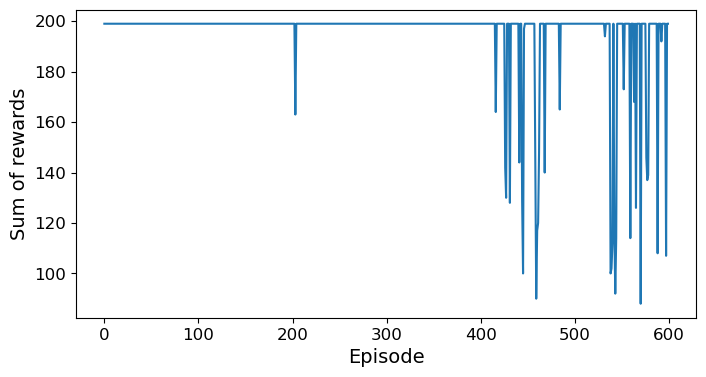

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [15]:
# Now show the animation:

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)